# 5a. Convolutional neural networks

A traditional multilayered perceptron has many limitations. For exxample, it does not take spatial structure of data into consideration. Let's not forget about the fact that fully connected layers lead to huge numbers of weights for images with high resolution and therefore make it impossible to process data efficiently. 

That's where CNNs (convolutional neural networks) come into play. The idea behind them is inspired by how the visual cortex analyzes images. It creates and adapts filters that extract features. In contrast to classical image classifiers, the filters are not hand-engineered by experts but trained automatically within the network.


## Key concepts of this section

1. **CIFAR10 dataset**
2. `torch.nn.Conv2d` layers
3. **Pooling layers in PyTorch**
4. Defining convolutional neural networks using `nn.Module` container.

In [1]:
from intro_to_pytorch import helper, data, cifar10

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import torch
from torch import nn
import torchvision

%matplotlib inline
import seaborn as sns
sns.set(style="darkgrid")

## CIFAR10

In this notebook, we will be working with the CIFAR10 dataset available in `torchvision`. It provides images of the objects of ten classes:

Files already downloaded and verified
Files already downloaded and verified


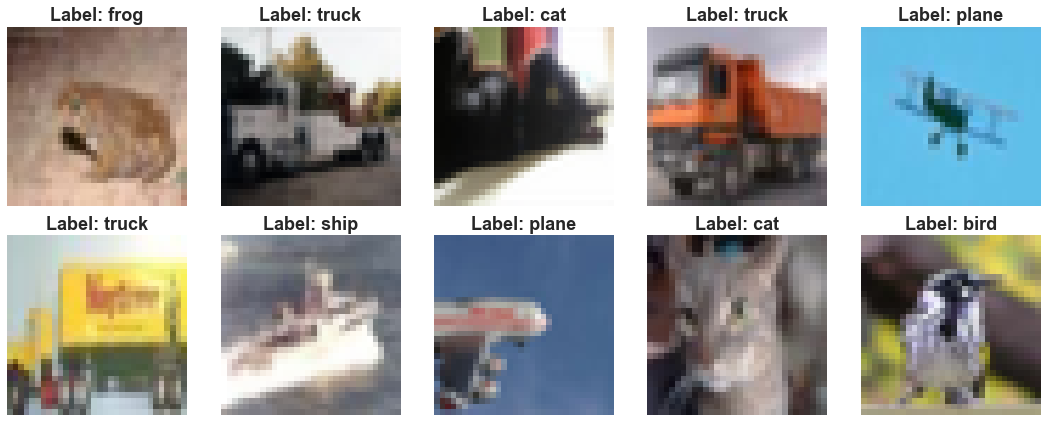

In [2]:
from torchvision import datasets, transforms

batch_size=64
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

train_cifar = datasets.CIFAR10(data.DATA_PATH, download=True, train=True, transform=transform)
test_cifar = datasets.CIFAR10(data.DATA_PATH, download=True, train=False, transform=transform)

trainloader = torch.utils.data.DataLoader(train_cifar, batch_size=batch_size, shuffle=True)
testloader = torch.utils.data.DataLoader(test_cifar, batch_size=batch_size, shuffle=True)

cifar10.show_data(trainloader, batch_size)

## CNN structure

Let's take a look at one of the built-in CNN model available in the `torchvision` library:

In [3]:
import torchvision.models as models
alexnet = models.alexnet()
alexnet

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

We can see that it contains many layers of different types. It may seem complicated at first, but those building blocks will be explained in this section - so don't worry.

### Convolutional layers

It is no surprise that convolutional layers are the core concept used in CNNs. The convolution is an operation that can be seen as applying filters to the images.

During model training, the convolutional layers 'learn' appropriate values for each filter.

In [4]:
convolutional_layer = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=0, stride=1)
print(convolutional_layer)

Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))


### Exercise 1:

Create a convolutional layer (conv2d) that is equivalent to applying a [Sobel filter](https://en.wikipedia.org/wiki/Sobel_operator).

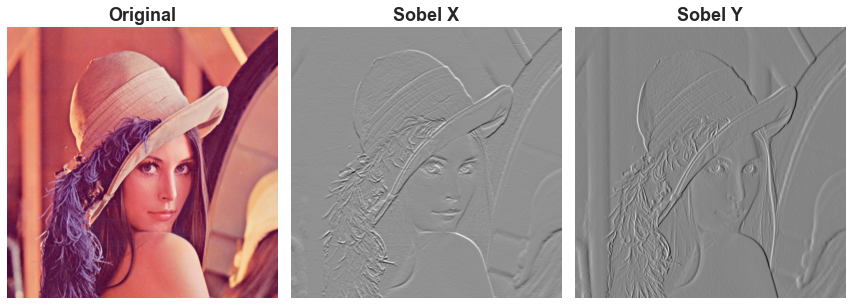

In [5]:
# Expected results
helper.show_filters()

In [6]:
sobel_x = torch.tensor([[-1., -2., -1.], [0., 0., 0.], [1., 2., 1.]]).expand([1, 3, 3, 3])

sobel_layer_x = nn.Conv2d(in_channels=3, out_channels=3, kernel_size=3, padding=0, stride=1, bias=False)
sobel_layer_x.weight.data = sobel_x

pd.DataFrame(data=sobel_x.squeeze().numpy()[0])

,0,1,2
0,-1.0,-2.0,-1.0
1,0.0,0.0,0.0
2,1.0,2.0,1.0


In [7]:
sobel_y = torch.tensor([[-1., 0, 1.], [-2., 0., 2.], [-1., 0., 1.]]).expand([1, 3, 3, 3])

sobel_layer_y = nn.Conv2d(in_channels=3, out_channels=3, kernel_size=3, padding=0, stride=1, bias=False)
sobel_layer_y.weight.data = sobel_y

pd.DataFrame(data=sobel_y.squeeze().numpy()[0])

,0,1,2
0,-1.0,0.0,1.0
1,-2.0,0.0,2.0
2,-1.0,0.0,1.0


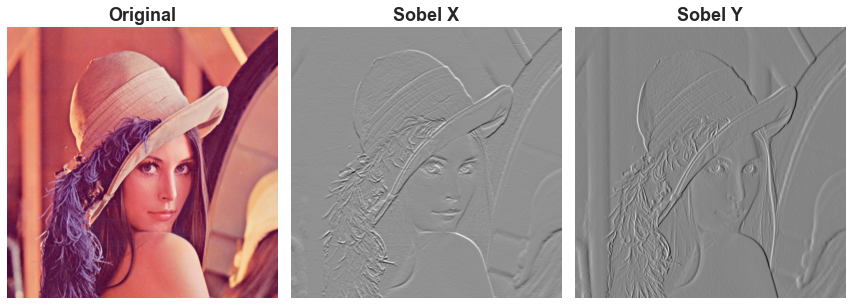

In [8]:
filters = {
    'Sobel X': (lambda img: sobel_layer_x(img)),
    'Sobel Y': (lambda img: sobel_layer_y(img))
}

with torch.no_grad():
    helper.show_filters(filters)

## Pooling layers

Using convolutional layers can lead to increasing dimension of the layers. In order to reduce the number of parameters in the network, we use pooling layers. These are the layers which down-sample their inputs by using a selected function (eg. maximum value within the frame). This process is presented in the picture below: 

![pooling layer](https://upload.wikimedia.org/wikipedia/commons/thumb/e/e9/Max_pooling.png/314px-Max_pooling.png "Max pooling layer") 
source: [wikipedia.org](https://upload.wikimedia.org/wikipedia/commons/thumb/e/e9/Max_pooling.png/314px-Max_pooling.png)

In [9]:
input_array = np.arange(-8, 8, dtype=np.float32).reshape((1,4,4))
input_layer = torch.from_numpy(input_array)

pd.DataFrame(data=input_layer.numpy().reshape((4,4)))

,0,1,2,3
0,-8.0,-7.0,-6.0,-5.0
1,-4.0,-3.0,-2.0,-1.0
2,0.0,1.0,2.0,3.0
3,4.0,5.0,6.0,7.0


### Max

One of the most popular types of pooling layers is max-pooling. As its name suggests, it takes the highest value within the kernel. In PyTorch, there are several variants of max-pooling:

- `nn.MaxPool2d` - simplest to use: you specify the size of the kernel, stride and padding yourself,
- `nn.AdaptiveMaxPool2d` - you specify the size of the desired output, size of the kernel - other parameters are adapted according to the given parameters,
- `nn.FractionalMaxPool2d` - applies fractional max pooling: you specify the size of the kernel and the size of the output/output ratio, described in detail in the paper [Fractional MaxPooling by Ben Graham](https://arxiv.org/abs/1412.6071)

### Exercise 2:

Declare a max-pooling layer, pass the input layer through it and display results.

In [10]:
max_pool = nn.MaxPool2d(2)
pd.DataFrame(data=max_pool(input_layer).numpy().reshape((2,2)))

,0,1
0,-3.0,-1.0
1,5.0,7.0


In [11]:
adp_max_pool = nn.AdaptiveMaxPool2d(output_size=(2,2))
pd.DataFrame(data=adp_max_pool(input_layer).numpy().reshape((2,2)))

,0,1
0,-3.0,-1.0
1,5.0,7.0


In [12]:
frac_max_pool = nn.FractionalMaxPool2d(2, output_size=(2, 2))
pd.DataFrame(data=frac_max_pool(input_layer).numpy().reshape((2,2)))

,0,1
0,-3.0,-1.0
1,5.0,7.0


### Average

Another type of pooling layer is average-pooling. Again, PyTorch provides several options to use it:

- `nn.AvgPool2d` - simplest to use: you specify the size of the kernel, stride and padding yourself,
- `nn.AdaptiveAvgPool2d` - you specify the size of the output, size of the kernel, other parameters are adapted according to the given parameters

### Exercise 3:

Declare an average-pooling layer, pass the input layer through it and display results.

In [13]:
avg_pool = nn.AvgPool2d(2)
pd.DataFrame(data=avg_pool(input_layer).numpy().reshape((2,2)))

,0,1
0,-5.5,-3.5
1,2.5,4.5


In [14]:
adp_avg_pool = nn.AdaptiveAvgPool2d(output_size=(2,2))
pd.DataFrame(data=adp_avg_pool(input_layer).numpy().reshape((2,2)))

,0,1
0,-5.5,-3.5
1,2.5,4.5


### Power average

The last type of built-in pooling in PyTorch is power-average-pooling, which calculates the output according to

\begin{equation}
f(X)=\sqrt[p]{\sum_{x \in X}x^p}
\end{equation}

If you use $p=1$, you get sum pooling. In the limit of $p \rightarrow \infty $, it converges to max-pooling.

### Exercise 4:

Declare a power-average-pooling layer, pass the input layer through it and display results.

In [15]:
lp_pool = nn.LPPool2d(2, 2)
pd.DataFrame(data=lp_pool(input_layer).numpy().reshape((2,2)))

,0,1
0,11.747340,8.124039
1,6.480741,9.899495


## Activation layers

Another block in CNNs are activation layers which were discussed in [Neural networks notebook](../3_Neural_networks/3a_Neural_network_module.ipynb). If you need to refresh your memory, please refer to the section Activation layers there.

### Exercise 5:

Declare a ReLU activation layer and pass the output of the pooling layer of your choice through it. Display the results.

In [16]:
act_layer = nn.ReLU()
pd.DataFrame(data=act_layer(adp_avg_pool(input_layer)).numpy().reshape((2,2)))

,0,1
0,0.0,0.0
1,2.5,4.5


## Classifier

The classifier is the last part of the network. It is a linear neural network which analyzes features extracted by the previous blocks and provides information about the predicted class. Again, for more about linear networks, please refer to [Neural networks notebook](../3_Neural_networks/3a_Neural_network_module.ipynb).

### Exercise 6:

Declare classifier similar to the one used in AlexNet.

In [17]:
classifier = nn.Sequential(
    nn.Dropout(),
    nn.Linear(in_features=9216, out_features=4096),
    nn.ReLU(),
    nn.Dropout(),
    nn.Linear(in_features=4096, out_features=4096),
    nn.ReLU(),
    nn.Linear(in_features=4096, out_features=1000),
  )
classifier

Sequential(
  (0): Dropout(p=0.5, inplace=False)
  (1): Linear(in_features=9216, out_features=4096, bias=True)
  (2): ReLU()
  (3): Dropout(p=0.5, inplace=False)
  (4): Linear(in_features=4096, out_features=4096, bias=True)
  (5): ReLU()
  (6): Linear(in_features=4096, out_features=1000, bias=True)
)

### Exercise 7

We discussed the basics of CNNs. Now it's time to implement your first network. Create network with:

- 3 convolutional layers, each followed by:
  * activation layer,
  * pooling layer,
  
- classifier with 2 linear layers, each:
  * preceeded with dropout layer,
  * followed by activation layers.

In [18]:
class Network(nn.Module):
    def __init__(self):
        super().__init__()
        
        # input 32x32x3
        self.conv_1 = nn.Conv2d(3, 16, 3, padding=1)
        # input 16x16x16
        self.conv_2 = nn.Conv2d(16, 32, 3, padding=1)
        # input 8x8x32
        self.conv_3 = nn.Conv2d(32, 64, 3, padding=1)
        
        # reduces size by 2
        self.pool = nn.MaxPool2d(2)
        
        # input 4x4x64 x64
        self.lin_1 = nn.Linear(4*4*64, 128)
        self.lin_2 = nn.Linear(128, 10)
        
        self.dropout = nn.Dropout()
        self.act = nn.ReLU()
        self.class_act = nn.Sigmoid()
        
    def forward(self, x):        
        x = self.pool(self.act(self.conv_1(x)))
        x = self.pool(self.act(self.conv_2(x)))
        x = self.pool(self.act(self.conv_3(x)))
        
        x = x.view(-1, 64 * 4 * 4)
        
        x = self.dropout(x)
        x = self.lin_1(x)
        x = self.act(x)
        
        x = self.dropout(x)
        x = self.lin_2(x)
        x = self.class_act(x)
        return x

In [19]:
network = Network()
network

Network(
  (conv_1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv_2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv_3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (lin_1): Linear(in_features=1024, out_features=128, bias=True)
  (lin_2): Linear(in_features=128, out_features=10, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (act): ReLU()
  (class_act): Sigmoid()
)

All methods required to test your network have already been implemented in [Training and validation notebook](../4_Training_and_validation/4c_training_loop_Solutions.ipynb).

Epoch: 1 	 Training loss: 2.07547 	 Test loss: 2.13547 	 Test accuracy: 0.21752


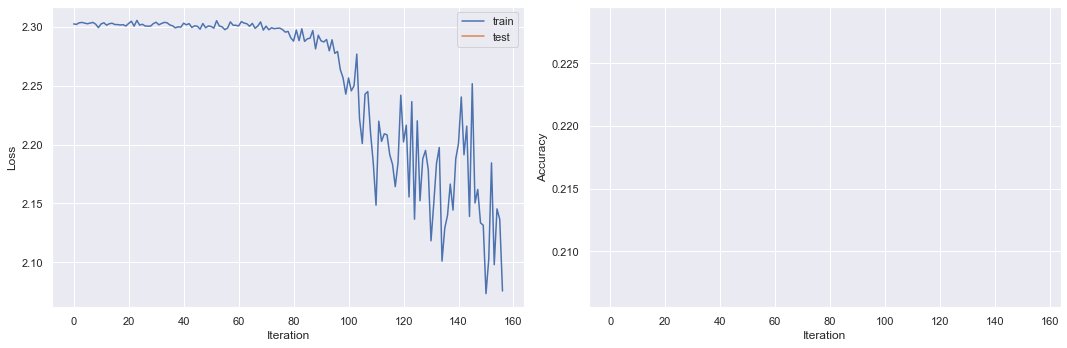

In [20]:
loss = nn.CrossEntropyLoss()
train_losses, test_losses, accuracies = cifar10.train_nn(network, loss, trainloader, testloader, n_epochs=1, lr=0.5)
cifar10.plot_metrics(train_losses, test_losses, accuracies)

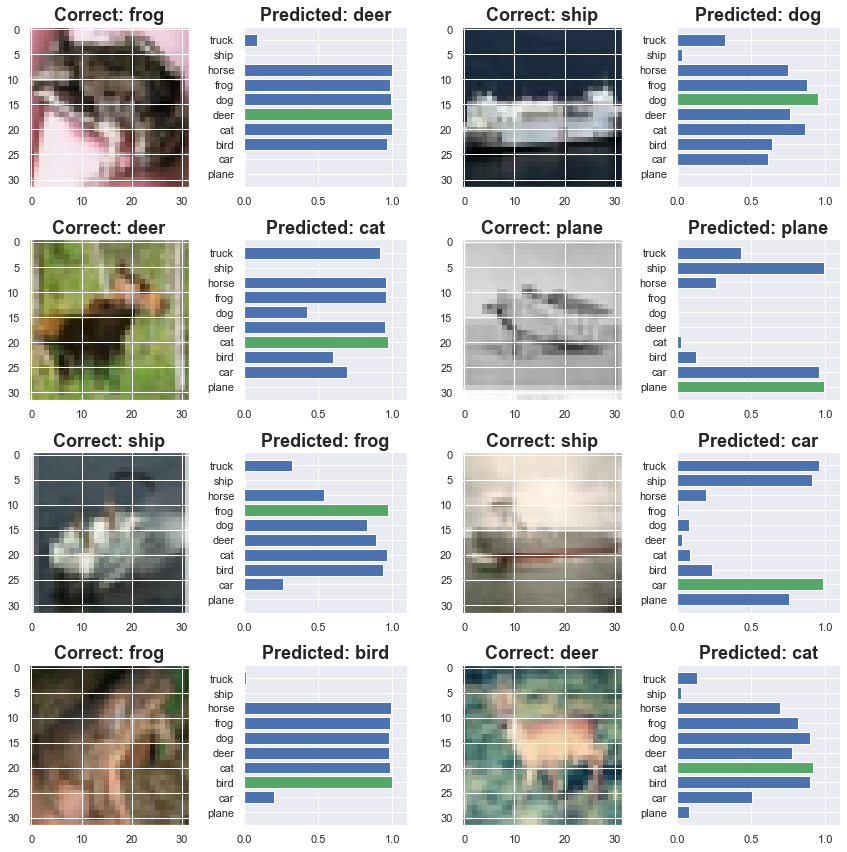

In [21]:
cifar10.show_classify(trainloader, network, batch_size)

## References

- [PyTorch NN module documentation](https://pytorch.org/docs/stable/nn.html)
- [Convolutional neural network](https://en.wikipedia.org/wiki/Convolutional_neural_network)
- [Convolutional layers for deep learning neural networks](https://machinelearningmastery.com/convolutional-layers-for-deep-learning-neural-networks/)